# Classification with oversampled data (SMOTE)

In [1]:
# import modules

import h5py
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, precision_recall_curve
from sklearn.metrics import precision_recall_fscore_support, classification_report, make_scorer
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential, load_model
from keras.layers import Dense, LeakyReLU
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
# read in data

data = pd.read_csv(r"C:\Users\hien\Desktop\masterdata\creditcard.csv")

## Data preprocessing

In [3]:
# Split into training and test set
x = data.iloc[:,:-1]      # dataframe without class feature
y = data.iloc[:,-1]       # selecting only class feature

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
print ("Training - fraud case: {:.2f}%".format(np.sum(y_train==1)/len(y_train)*100))
print ("Testing - fraud case: {:.2f}%".format(np.sum(y_test==1)/len(y_test)*100))
print ("# Fraud in training: ", np.sum(y_train==1))
print ("# Non-fraud in training: ", np.sum(y_train==0))
print ("# Fraud in test: ", np.sum(y_test==1))
print ("# Non-fraud in test: ", np.sum(y_test==0))


Training - fraud case: 0.17%
Testing - fraud case: 0.17%
# Fraud in training:  394
# Non-fraud in training:  227451
# Fraud in test:  98
# Non-fraud in test:  56864


In [4]:
#scaling amount and time to prevent data leakage

scale_amount = RobustScaler()
scale_time = RobustScaler()


scale_amount.fit(x_train.iloc[:,-1:])
x_train.iloc[:,-1:] = scale_amount.transform(x_train.iloc[:,-1:])
x_test.iloc[:,-1:]= scale_amount.transform(x_test.iloc[:,-1:])


scale_time.fit(x_train.iloc[:,0:1])
x_train.iloc[:,0:1] = scale_time.transform(x_train.iloc[:,0:1])
x_test.iloc[:,0:1] = scale_time.transform(x_test.iloc[:,0:1])


C:\Users\hien\anaconda\envs\new_env\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\hien\anaconda\envs\new_env\lib\site-packages\pandas\core\indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)
C:\Users\hien\anaconda\envs\new_env\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_

In [5]:
# SMOTE is applied to sub-training set to prevent data leakage
# Split training set into sub-training set for SMOTE and validation set to prevent data leakage
x_subtrain, x_val, y_subtrain, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state = 39)

print ("# Fraud in training: ", np.sum(y_subtrain==1))
print ("# Non-fraud in training: ", np.sum(y_subtrain==0))
print ("# Fraud in validation: ", np.sum(y_val==1))
print ("# Non-fraud in validation: ", np.sum(y_val==0))


# Fraud in training:  313
# Non-fraud in training:  181963
# Fraud in validation:  81
# Non-fraud in validation:  45488


In [6]:
# Oversampling minority class using SMOTE
smote = SMOTE(random_state=42)
x_subtrain_smote, y_subtrain_smote = smote.fit_resample(x_subtrain, y_subtrain)
print ("Percentage of cases with class 1 for training:{:.4f}".format(np.sum(y_subtrain_smote==1)/len(y_subtrain_smote)))
print ("Percentage of cases with class 1 for test:{:.4f}".format(np.sum(y_test==1)/len(y_test)), "\n")

Percentage of cases with class 1 for training:0.5000
Percentage of cases with class 1 for test:0.0017 



In [7]:
print ("# Fraud in training: ", np.sum(y_subtrain_smote==1))
print ("# Non-fraud in training: ", np.sum(y_subtrain_smote==0))
print ("# Fraud in validation: ", np.sum(y_val==1))
print ("# Non-fraud in validation: ", np.sum(y_val==0))
print ("# Fraud in test: ", np.sum(y_test==1))
print ("# Non-fraud in test: ", np.sum(y_test==0))

# Fraud in training:  181963
# Non-fraud in training:  181963
# Fraud in validation:  81
# Non-fraud in validation:  45488
# Fraud in test:  98
# Non-fraud in test:  56864


## Model implementation

In [8]:
from sklearn.neural_network import MLPClassifier



In [9]:
'''MLPC = MLPClassifier(hidden_layer_sizes=(200,), max_iter=10000)
MLPC.fit(x_subtrain_smote, y_subtrain_smote)
y_pred = MLPC.predict(x_test)

recall_acc = recall_score (y_test,y_pred)
recall_acc '''

'MLPC = MLPClassifier(hidden_layer_sizes=(200,), max_iter=10000)\nMLPC.fit(x_subtrain_smote, y_subtrain_smote)\ny_pred = MLPC.predict(x_test)\n\nrecall_acc = recall_score (y_test,y_pred)\nrecall_acc '

In [10]:
#precision_score(y_test,y_pred)

In [11]:
from keras.layers import Dropout
from keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv1D, MaxPool1D

In [12]:
x_subtrain_smote.shape[1]

30

In [13]:
x_subtrain_smote.shape[0]

363926

In [8]:
input_size = x_subtrain_smote.shape[1]
epochs = 50
batch_size = 8192
save_best_model = "desktop\smote12_credit_card_fraud_model.hdf5"

In [15]:
#classifier = Sequential()
#classifier.add(Dense(8192, activation="relu", input_shape=(input_size,)))
#classifier.add(BatchNormalization())
#classifier.add(Dropout(0.7))

#classifier.add(Dense(2048, activation="relu"))
#classifier.add(BatchNormalization())
#classifier.add(Dropout(0.5))




#classifier.add(Dense(1, activation="sigmoid"))

#classifier.summary()



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8192)              253952    
_________________________________________________________________
batch_normalization (BatchNo (None, 8192)              32768     
_________________________________________________________________
dropout (Dropout)            (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2048)              16779264  
_________________________________________________________________
batch_normalization_1 (Batch (None, 2048)              8192      
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 2

Epoch 1/50
23/23 [==============================] - 797s 35s/step - loss: 0.5015 - accuracy: 0.9220 - val_loss: 1.2910 - val_accuracy: 0.3663
Epoch 2/50
23/23 [==============================] - 836s 36s/step - loss: 0.0748 - accuracy: 0.9688 - val_loss: 0.5112 - val_accuracy: 0.7141
Epoch 3/50
23/23 [==============================] - 840s 37s/step - loss: 0.0448 - accuracy: 0.9840 - val_loss: 0.1689 - val_accuracy: 0.9406
Epoch 4/50
23/23 [==============================] - 831s 36s/step - loss: 0.0282 - accuracy: 0.9912 - val_loss: 0.0784 - val_accuracy: 0.9762
Epoch 5/50
23/23 [==============================] - 830s 36s/step - loss: 0.0195 - accuracy: 0.9948 - val_loss: 0.0370 - val_accuracy: 0.9887
Epoch 6/50
23/23 [==============================] - 840s 37s/step - loss: 0.0143 - accuracy: 0.9968 - val_loss: 0.0228 - val_accuracy: 0.9927
Epoch 7/50
23/23 [==============================] - 834s 36s/step - loss: 0.0115 - accuracy: 0.9976 - val_loss: 0.0166 - val_accuracy: 0.9945
Epoch 

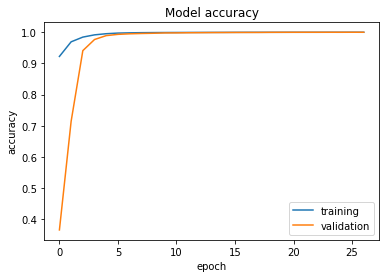

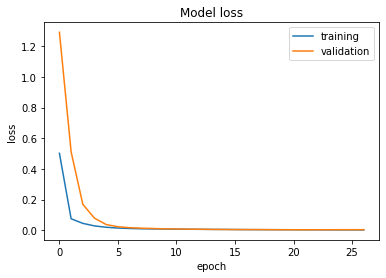

In [16]:
#classifier.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
#checkpoint = ModelCheckpoint(save_best_model, monitor="val_loss", save_best_only=True, save_weights_only=False)
#earlystop = EarlyStopping(monitor="val_loss", patience=5)
#callbacks_list = [checkpoint, earlystop]
#history = classifier.fit(x_subtrain_smote, y_subtrain_smote, validation_data=(x_val, y_val), epochs=epochs, batch_size=batch_size, callbacks=callbacks_list, shuffle=True)


# summarize history for accuracy
#plt.plot(history.history['accuracy'])
#plt.plot(history.history['val_accuracy'])
#plt.title('Model accuracy')
#plt.ylabel('accuracy')
#plt.xlabel('epoch')
#plt.legend(['training', 'validation'], loc='lower right')
#plt.show()

# summarize history for loss
#plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
#plt.title('Model loss')
#plt.ylabel('loss')
#plt.xlabel('epoch')
#plt.legend(['training', 'validation'], loc='upper right')
#plt.show()

## Classification results

In [9]:
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import auc

In [10]:
classifier = load_model(save_best_model)
y_pred = classifier.predict(x_test)
y_pred = y_pred>=0.5

cm = confusion_matrix(y_test, y_pred)
print ("Confusion matrix:\n", cm)
print ("\n")



print ("accuracy: {:.2f}".format(accuracy_score(y_test, y_pred)))
print ("precision: {:.2f}".format(precision_score(y_test, y_pred)))
print ("recall: {:.2f}".format(recall_score(y_test, y_pred)))
print ("f1 score: {:.2f}".format(f1_score(y_test, y_pred)))
print ("Average precision: {:.2f}".format(average_precision_score(y_test, y_pred)))
print ("AUC-ROC: {:.2f}".format(roc_auc_score(y_test, y_pred)))

precision, recall, _ = precision_recall_curve(y_test, y_pred)


auc_score = auc(recall, precision)
print('Logistic PR AUC: %.3f' % auc_score)

Confusion matrix:
 [[56847    17]
 [   16    82]]


accuracy: 1.00
precision: 0.83
recall: 0.84
f1 score: 0.83
Average precision: 0.69
AUC-ROC: 0.92
Logistic PR AUC: 0.833


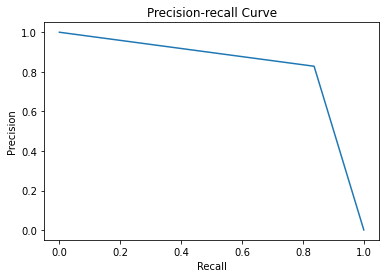

In [11]:
plt.plot(recall, precision)
plt.title("Precision-recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

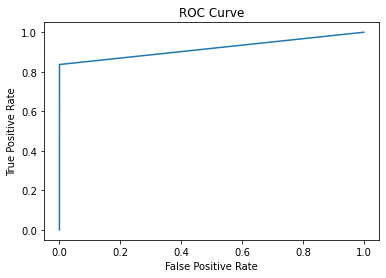

In [12]:
fpr, tpr, _ = roc_curve(y_test, y_pred)
# plot the roc curve for the model

plt.plot(fpr, tpr)
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC Curve")
# show the legend
#plt.legend()
# show the plot
plt.show()



In [13]:
fpr

array([0.0000000e+00, 2.9895892e-04, 1.0000000e+00])

In [14]:
tpr

array([0.        , 0.83673469, 1.        ])

## Feature impact with SHAP

In [19]:
import shap
from ipywidgets import IntProgress



In [32]:
#background = x_train[:100]# we use the first 100 training examples as our background dataset to integrate over

background = shap.kmeans(x_train, 100)
explainer = shap.KernelExplainer(classifier.predict, background)



In [33]:
random_100_x_test = x_test.sample(n=100)

shap_values = explainer.shap_values(random_100_x_test, nsamples=100)

  0%|          | 0/100 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Feature Impact (SMOTE-Data)')

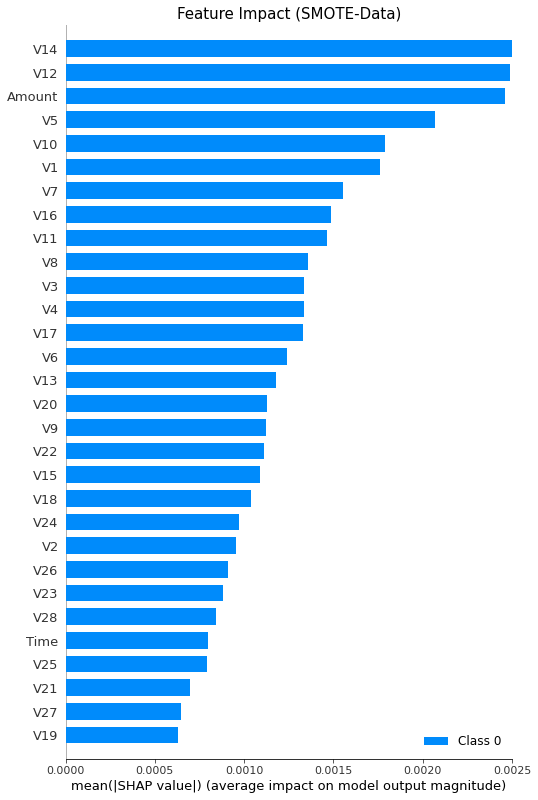

In [36]:
shap.summary_plot(shap_values, x_test, max_display=30, show=False)

# Get the current figure and axes objects.
fig, ax = plt.gcf(), plt.gca()

# Make the modifications that you want. I wanted
# to resize the x-axis, but you can do anything that you'd like.
xlim = 0.0025
ax.set_xlim(0, xlim)
ax.set_title("Feature Impact (SMOTE-Data)", fontdict={"size":15})

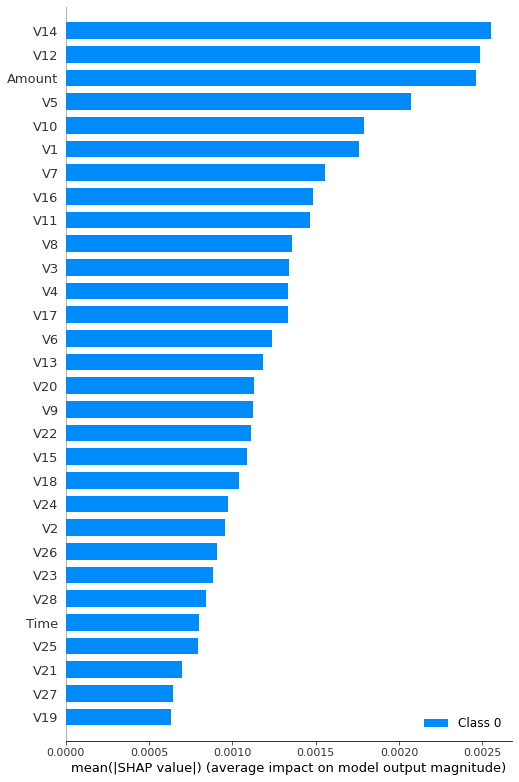

In [35]:
shap.summary_plot(shap_values, x_test, max_display=30)